# Ejercicio 3 - Análisis de emociones en texto no-estructurado (NLP)

La idea es realizar un análisis de emociones desde comentarios en medios sociales, por medio de un modelo de clasificación supervisada, que entrega una de 3 posibles clases de emoción.

## Contexto: Análisis de texto de comentarios en medios sociales de diversos países (Chile, Arg, Mex, otros)

Este conjunto de datos generado en 2016 por [R:Solver](http://rsolver.com) y compartido parcialmente para este tipo de ejercicios, consiste en dos columnas: el texto del comentario, y una clasificación dentro de las tres alternativas o clases de emoción.

El gran objetivo final a resolver con este ejemplo, es analizar una porción de texto y lograr predecir la emoción correspondiente, dentro de 3 posibles clases:

*     Enojo
*     Sorpresa
*     Alegría

**CONSIDERACIÓN IMPORTANTE**

Se sabe que para lograr buenos resultados se requiere contar con muchos miles de ejemplos y en este ejercicio académico sólo se cuenta con pocos miles por cada clase. **En la práctica se podrá apreciar que el desempeño general (*accuracy*) de los modelos es mediano-bajo (cerca del 50%). Esto, seguramente, podría mejorar recién al contar con varias decenas de miles de ejemplos adicionales a los actuales**, lo que se explica por la gran diversidad de terminología encontrada en estos comentarios (son cerca de 20.000 términos o palabras diferentes en este corpus).

Por esta razón, el foco está en realizar análisis sobre estos desempeños y sacar conclusiones útiles, hasta cierto punto independiente de los *accuracies* correspondientes. Este ejercicio busca reforzar conceptos desde la perspectiva de quienes ya están adentrándose más en entender el funcionamiento de modelos de clasificación supervisada.

---

## Instrucciones Generales

Se deben contestar las preguntas que se indican en las secciones de "Preguntas", más adelante. Se puede recurrir a ejercicios de otras fuentes, así como al material de clases.

La entrega se realiza en forma de un informe en formato PDF, utilizando la plantilla de informe que está en http://dcc.rsolver.com/dcc/docs/InformeActividad.docx

Esta entrega se puede subir por un único miembro del grupo a la tarea o registro en el portal del curso.

En caso de no poder subirlo por esa vía o que no esté habilitado, se puede usar el buzón alternativo: http://aiker.rsolver.com/aiker/DocUpload.aspx (*)

(*) Si y solo si hay problemas en la carga, enviar el PDF a rsandova@ing.puc.cl y cc: ayudante@aiker.ai


## Paso 1: Instalar librerías de modelos de clasificación

In [ ]:
install.packages('e1071')
install.packages('caret')
install.packages('caTools')
install.packages('tm')
install.packages('rpart')
install.packages('rpart.plot')
install.packages('SnowballC')
install.packages('nnet')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘proxy’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘iterators’, ‘Rcpp’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘bitops’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘NLP’, ‘slam’, ‘BH’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’


In [ ]:
library(dplyr)
library(tm)
library(SnowballC)
library(caTools)
library(caret)
library(rpart)
library(rpart.plot)
library(nnet)

## Paso 2: Carga de los datos

La siguiente celda de código carga los datos desde la URL de origen y luego muestra un encabezado con las primeras filas del dataset, para demostrar la disposición y ejemplos de los datos.

**Nótese que hay un desbalance entre los ejemplos de cada una de las 3 clases, pero NO se espera ni se pide modificar esto, lo cual queda a criterio de los alumnos experimentar con re-balancear las clases y ver su desempeño.**


In [ ]:
# Se declara la URL de dónde obtener los datos
theUrlMain <- "http://RAlize.RSolver.com/RAlize/data/small_emotion_sample_2016.csv"

# Se declaran los nombres de las columnas
columnas <- c("texto","emoción")

# Se cargan datos principales a una estructura (commentsdataset), asignando
# nombres de atributos a las columnas.
comments.dataset.raw <- read.csv(file = theUrlMain, header = FALSE, sep = ";", col.names=columnas, skipNul = TRUE)

In [ ]:
# Conteo de ejemplos de cada clase.
# Al ver su dimensión, se puede apreciar si están o no balanceados,
# pero no se espera en esta ocasión trabajar en balanceo de clases.
data.enojo <- comments.dataset.raw[comments.dataset.raw$emoción == 'enojo',]
data.sorpresa <- comments.dataset.raw[comments.dataset.raw$emoción == 'sorpresa',]
data.alegria <- comments.dataset.raw[comments.dataset.raw$emoción == 'alegria',]
cat("\nEjemplos Enojo:     ", dim(data.enojo))
cat("\nEjemplos Sorpresa:  ", dim(data.sorpresa))
cat("\nEjemplos Alegría:   ", dim(data.alegria))

commentsdataset <- comments.dataset.raw
dim(commentsdataset)
head(commentsdataset, 20)


Ejemplos Enojo:      3054 2
Ejemplos Sorpresa:   1085 2
Ejemplos Alegría:    2762 2

[1] 6901    2

,texto,emoción
,<chr>,<chr>
1,!FAVOR REVISAR DICCIONARIO !,enojo
2,?El Dodge Challenger cuantos kilometros por litro dara? Esa es mi consulta,sorpresa
3,"el trasero trailer de la version en carne y hueso , esos redactores merecen el premio redactor de excelencia jajaj",alegria
4,No sera un Peruano o Boliviano que lo hace para que sancionen a Chile ? Hay que acordarse de la guerra mediatica y todos los reclamos de parte de Evo A ese Evo tambien se le sospecha que fue quien dio la orden del reclamo boliviano por los canticos en el estadio,enojo
5,Y Renaca y Concon para levantar carpas en la playa,sorpresa
6,"Yo siempre compro por internet pero cada vez que hay Cyber Monday termino decepcionado, es mas la publicidad que reales ofertas",enojo
7,! Arjonaaaa !!!!! !Este otro ano vas fijo !!!!,sorpresa
8,!Partidazo!,alegria
9,"Medicion de pobreza, mas moderna y transparente: En enero de 2014 la Comision para la Medicion de la Pobreza, planteo un conjunto de propuestas de actualizacion de la metodologia de medicion de pobreza por ingresos, asi como la incorporacion de un enfoque de medicion multidimensional Sus sugerencias fueron recibidas por el gobierno de la Presidenta Bachelet y analizadas en detalle durante 2014 por una Mesa Tecnica Interinstitucional, conformada por el Ministerio de Desarrollo Social (MDS) y el Instituto Nacional de Estadisticas (INE), con el apoyo tecnico de Comision Economica para America Latina (CEPAL) En el ambito de la pobreza multidimensional, se conto ademas con la asesoria permanente de la Iniciativa para la Pobreza y el Desarrollo Humano de la Universidad de Oxford (OPHI, por su sigla en ingles)",sorpresa


## Ejercicio 1: Entender el efecto de la normalización de texto

Las técnicas de normalización de texto, cuando tienen que realizar análisis del texto leído, deben buscar la simplificación del texto para poder trabajar sobre un universo de términos más simple y acotado. Esto puede considerar eliminar tildes, evitar palabras comunes, usar la raíz de múltiples términos, entre otros.

A continuación se aplican algunas de las técnicas más frecuentes, permitiendo ver el efecto (potencialmente positivo) de cada una de ellas.

**Pregunta 1.1 (1 punto)**: ¿Cuánto mejora el rendimiento de los modelos de análisis de sentimiento (implementados en la siguiente sección) al agregar las técnicas de normalización? La idea es comparar el rendimiento con y sin las técnicas de normalización, analizando cuantitativamente las posibles mejoras en cada uno de los dos modelos (a nivel de sus indicadores de desempeño).

**Pregunta 1.2 (0,5 puntos)**: ¿Cuál es el modelo que mejora más? Analice y describa qué característcas de este modelo justifican ser el que mejora con las técnicas de normalización, más que el otro.

Aquí se recomienda registrar el desempeño de los modelos habiendo ejecutado con y sin las técnicas de normalización. Para verificar el desempeño SIN la normalización se puede eliminar las 5 instrucciones o técnicas que están el código como Bloque 1 (se recomienda comentar la línea de código respectivo con un símbolo #).

Se debe comparar el desempeño de ambos modelos, con y sin las normalizaciones de texto, de modo de ver en cuál de ellos tiene más efecto. Para efectos prácticos, se propone realizar la modificación en el BLOQUE 1 y correr todas las secciones de código en adelante, para ver el rendimiento comparado.  

Luego de contestar estas preguntas, continue con el ejercicio dejando activas las técnicas de normalización en adelante.

In [ ]:
# Construye el Corpus: el universo de texto que se usará para entrenar los
#modelos.
corpus.original <- Corpus(VectorSource(commentsdataset$texto))

# Se selecciona y muestra (sin normalizar) un comentario de ejemplo aleatorio
#dentro del corpus.
random_index <- floor(runif(1, min = 0, max = length(corpus.original)))
content(corpus.original[[random_index]])

################################
# NORMALIZACIÓN DEL TEXTO
# EJERCICIO: probar comentando (anteponiendo #) estas acciones, para ver cuánto
# es el efecto en el rendimiento del modelo de clasificación.
# La advertencia “transformation drops documents” es esperable y no incide en
# el resultado de la normalización.
################################

## BLOQUE 1
# Se pasan todas las palabras a minúsculas
corpus.normalizado <- tm_map(corpus.original, tolower)
# Se eliminan todos los signos de puntuación
corpus.normalizado <- tm_map(corpus.normalizado, removePunctuation)
# Se eliminan todos los números
corpus.normalizado <- tm_map(corpus.normalizado, removeNumbers)
# Se eliminan las stop words (palabras comunes, irrelevantes)
corpus.normalizado <- tm_map(corpus.normalizado, removeWords, c(stopwords("spanish")))
# Se lleva cada palabra a su raíz (stemming)
corpus.normalizado <- tm_map(corpus.normalizado, stemDocument)


# Se muestra el mismo ejemplo aleatorio, pero en texto normalizado
content(corpus.normalizado[[random_index]])

[1] " Asi es Berger se salio un poco antes, y por eso su choque con el muro fue mas tangencial Se le desprendio parte del aleron delantero y no pudo doblar "

Warning message in tm_map.SimpleCorpus(corpus.original, tolower):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus.normalizado, removePunctuation):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus.normalizado, removeNumbers):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus.normalizado, removeWords, c(stopwords("spanish"))):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus.normalizado, stemDocument):
“transformation drops documents”


[1] "asi berger salio choqu muro mas tangenci desprendio part aleron delantero pudo doblar"

## Ejercicio 2: Construcción de un Vocabulario con Términos Significativos

Los clasificadores reciben un X de entrada de una dimensión fija. Por lo tanto los X de este ejemplo de análisis de texto, comentarios de cantidad variable de palabras, no se pueden usar tal cual vienen (como lista de cantidad variables de términos).

Por ello, la siguiente porción de código transforma los comentarios de texto variable en un vector de ocurrencia de palabras referenciando un vocabulario, el cual se construye referenciando todas las palabras distintas (ya normalizadas) del Corpus. Esto se traduce en que un comentario que tiene la expresión ".. resultados excelentes ... ", tendría una intersección con el comentario "... excelente como resultó ..." y por ello podrían ser interpretadas en forma equivalente.

Pero el desafío de esta vectorización en base a un vocabulario es la **cantidad de dimensiones** (cantidad de palabras diferentes). Un vocabulario perfectamente puede tener varios miles de palabras diferentes (ver resultado en 2.A), entonces la dimensión del vector X es de esos varios miles.

Esto motiva a reducir la dimensionalidad del problema (el tamaño del vocabulario) al reconocer cuáles son los términos más relevantes. Esto se hace con removeSparseTerm() y un umbral alto (0.995 reduce la gran cantidad de términos que tienen al menos un 99.5% de 0s en la columna), como se ve en en 2.B. Mientras mayor es el número, mayor cantidad de términos ocasionales o esporádicos se conservan y el vocabulario queda más grande. En otras palabras, mientras menor es el número, mayor es la exigencia para un término de ser considerado valioso y quedar como parte del dataset. (https://www.rdocumentation.org/packages/tm/versions/0.7-8/topics/removeSparseTerms)

La pregunta específica a responder cuando se implementa un modelo es: ¿cuántos son los términos a considerar en el vocabulario que sean los mejores representativos del universo de diversas palabras, para maximizar el desempeño del modelo de clasificación? Eso se responde buscando un factor de removeSparseTerms() que logre ese mejor desempeño.

**Pregunta 2.1 (1 punto)** ¿Cuál es el valor usado en removeSparseTerm() para lograr mejores resultados en los modelos de clasificación? Realice una comparación de 3 valores: 0.990, 0.995, 0.998. (La comparación es con los modelos contra sí mismos, no entre modelos).

**Pregunta 2.2 (1 punto)** ¿Cómo se interpreta en este caso que mejore o empeore con más y a veces con menos cantidad de palabras (o columnas del dataset)?

Para ambas preguntas se debe comparar los resultados del Árbol de Decisión y de la Red Neuronal (utilizando parámetros de ejecución más liviana - ej: size=20 y maxit=30).


In [ ]:
#######################################################
# Indexación de términos: creación de un Vocabulario
#######################################################

# Primero una matriz de ocurrencia de términos o palabras (DTM: Document-term matrix).
# Las filas son los comentarios y las columnas son las palabras diferentes encontradas (varios miles).
termMatrix1 <- DocumentTermMatrix(corpus.normalizado)
# Resultado 2.A -> Las columnas son todos los términos diferentes encontrados en corpus
dim(termMatrix1)

# Entonces, se eliminan las palabras menos relevantes (sparse terms: términos dispersos)
# lo que resulta en una reducción dimensional (potencialmente grande)
# Ejercicio 2.1: ¿qué factor de eliminación (en rango 0.99x) da mejores resultados?
# Probar con 3 combinaciones: 0.990, 0.995, 0.998.
# Ejercicio 2.2: ¿qué implica o cómo se interpreta ese cambio de valor y su efecto en el dataset?
termMatrixLight1 <- removeSparseTerms(x = termMatrix1, sparse = 0.995)
dim(termMatrixLight1)  # Resultado 2.B -> Se puede ver que se reduce significativamente la cantidad de columnas (palabras)

# Re-formatea como un DataFrame
corpus.procesado_1 <- as.data.frame(as.matrix(termMatrixLight1))

# Se construye el dataset para entrenamiento, recuperando el comentario original, sin procesar
# agregando la columna "emoción"
corpus.procesado_1$emoción <- as.factor(commentsdataset$emoción)

# Se muestra el vocabulario y su tamaño
dim(corpus.procesado_1)

[1]  6901 16848

[1] 6901  195

[1] 6901  196

In [ ]:
# Se indexan los términos para el corpus original, NO NORMALIZADO

# Matriz de ocurrencia de términos o palabras (DTM: Document-term matrix).
termMatrix2 <- DocumentTermMatrix(corpus.original)
dim(termMatrix2)

# Entonces, se eliminan las palabras menos relevantes (sparse terms: términos dispersos)
termMatrixLight2 <- removeSparseTerms(x = termMatrix2, sparse = 0.995)
dim(termMatrixLight2)

# Re-formatea como un DataFrame
corpus.procesado_2 <- as.data.frame(as.matrix(termMatrixLight2))
corpus.procesado_2$emoción <- as.factor(commentsdataset$emoción)

# Se muestra el vocabulario y su tamaño
dim(corpus.procesado_2)

[1]  6901 22553

[1] 6901  216

[1] 6901  217

## Paso 3: Ejecución modelos de predicción según conjuntos de entrenamiento y validación

En este caso, el dataset de ejemplos etiquetados se divide en dos (Hold-out) para entrenar y validar con conjuntos disjuntos.

No se necesita modificar esta sección, aunque es válido y potencialmente interesante revisar diferentes valores de proporción entrenamiento/validación.


In [ ]:
################################################################
# Versión simple para crear conjuntos de entrenamiento y de test.
# Se puede dejar la proporción original de 0.70,
# pero se puede cambiar si se piensa que puede hacer una diferencia.
set.seed(12345)
ratio_1 <- sample(nrow(corpus.procesado_1), nrow(corpus.procesado_1) * 0.70)
training.set_1 = corpus.procesado_1[ratio_1,]
testing.set_1 = corpus.procesado_1[-ratio_1,]

cat("Dimensiones Entrenamiento/Test")
dim(training.set_1)
dim(testing.set_1)

head(testing.set_1, 10)

Dimensiones Entrenamiento/Test

[1] 4830  196

[1] 2071  196

,favor,cuanto,chile,dio,hace,part,sera,tambien,cada,mas,⋯,via,falabella,…,transantiago,artifici,monsanto,transgenico,camilavallejo,gustado,emoción
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
7,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,sorpresa
8,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,alegria
10,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,enojo
12,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,sorpresa
13,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,alegria
17,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,enojo
26,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,alegria
27,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,alegria
29,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,sorpresa


In [ ]:
# Versión simple para crear conjuntos de entrenamiento y de test en corpus
# no normalizado
set.seed(12345)
ratio_2 <- sample(nrow(corpus.procesado_2), nrow(corpus.procesado_2) * 0.70)
training.set_2 = corpus.procesado_2[ratio_2,]
testing.set_2 = corpus.procesado_2[-ratio_2,]

cat("Dimensiones Entrenamiento/Test")
dim(training.set_2)
dim(testing.set_2)

head(testing.set_2, 10)

Dimensiones Entrenamiento/Test

[1] 4830  217

[1] 2071  217

,esa,por,chile,del,ese,fue,hace,hay,los,para,⋯,risa,transantiago,mcdonald's,artificial,transgenicos,…,juan,monsanto,gustado,emoción
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
7,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,sorpresa
8,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,alegria
10,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,enojo
12,0,0,0,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,sorpresa
13,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,alegria
17,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,enojo
26,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,alegria
27,0,2,0,1,0,0,0,0,3,1,⋯,0,0,0,0,0,0,0,0,0,alegria
29,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,sorpresa


## Ejercicio 3: Interpretación de desempeño de modelos de clasificación de referencia

Habiendo definido y establecido los conjuntos de entrenamiento y de test, a continuación se ejecutan dos diferentes modelos de clasificación: Árbol de Decisión y más abajo una Red Neuronal (NNET). Cada uno obtiene su resultado, mostrando sus indicadores de desempeño.

Nótese que ninguno de los 2 modelos da resultados significativamente buenos o mucho mejor que el otro, lo cual se debe a la inherente complejidad de los casos de lenguaje natural y contar sólo con unos pocos miles de ejemplos (en total son cerca de 7.000 ejemplos, divididos en 3 clases, lo cual no alcanza a reflejar la real diversidad de palabras asociadas a cada una de las clases, cosa que se empieza a lograr desde las decenas de miles de ejemplos por clase).

Sin embargo, hay algunas observaciones que salen de los resultados de desempeño, además del hecho de que la red neuronal toma cerca de 10x el tiempo del Árbol de Decisión. De estas observaciones, se pide responder lo siguiente.

**Pregunta 3.1 (1 punto)** Considere cambiar los parámetros de funcionamiento de la red neuronal (size, maxit) buscando su mejor desempeño e indique los valores de estos dos parámetros que resultó en mejores resultados.

**Pregunta 3.2 (0,7 punto)** Teniendo este resultado se ve que de los dos modelos, hay uno con *accuracy* mejor que el otro, pero en forma más completa y precisa ¿cuál de los dos se puede considerar el mejor modelo al mirar su desempeño más completo y por qué? Nótese que la tabla de resultados tiene una serie de indicadores diferentes por cada una de las 3 clases, que sirven para entender cómo se comporta el modelo en una correcta clasificación.

**Pregunta 3.3 (0,8 punto)** Se puede observar que el Árbol de Decisión tiene un muy mal desempeño en reconocer una de esas clases. ¿Cuál y por qué podría darse esto? (En otras palabras, ¿qué característica de este modelo puede provocar que en este caso una de las clases no sea factible de predecir?


**Árbol de Decisión**

In [ ]:
set.seed(12345)
DT_model_1 <- rpart(
  formula = emoción ~ .,
  data = training.set_1,
  method = "class",
  minbucket = 20
)

DT_predictTraining_1 <- predict(DT_model_1, training.set_1, type = "class")
DT_predictTesting_1 <- predict(DT_model_1, testing.set_1, type = "class")
cat("************* Resultados Árbol de Decisión - Testing *************\n")
cat("************** Corpus normalizado y Sparce > 0,995 ***************\n")
confusionMatrix(DT_predictTesting_1, as.factor(testing.set_1$emoción))

************* Resultados Árbol de Decisión - Testing *************
************** Corpus normalizado y Sparce > 0,995 ***************


Confusion Matrix and Statistics

          Reference
Prediction alegria enojo sorpresa
  alegria       33     2        0
  enojo        832   875      329
  sorpresa       0     0        0

Overall Statistics
                                          
               Accuracy : 0.4384          
                 95% CI : (0.4169, 0.4601)
    No Information Rate : 0.4235          
    P-Value [Acc > NIR] : 0.08763         
                                          
                  Kappa : 0.0261          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: alegria Class: enojo Class: sorpresa
Sensitivity                 0.03815      0.99772          0.0000
Specificity                 0.99834      0.02764          1.0000
Pos Pred Value              0.94286      0.42976             NaN
Neg Pred Value              0.59136      0.94286          0.8411
Prevalence                  0.41767      0.42347        

In [ ]:
# Árbol de decisiones con corpus sin normalizar
set.seed(12345)
DT_model_2 <- rpart(
  formula = emoción ~ .,
  data = training.set_2,
  method = "class",
  minbucket = 20
)

DT_predictTraining_2 <- predict(DT_model_2, training.set_2, type = "class")
DT_predictTesting_2 <- predict(DT_model_2, testing.set_2, type = "class")
cat("************* Resultados Árbol de Decisión - Testing *************\n")
cat("************* Corpus no normalizado y Sparce > 0,995 *************\n")
confusionMatrix(DT_predictTesting_2, as.factor(testing.set_2$emoción))

************* Resultados Árbol de Decisión - Testing *************
************* Corpus no normalizado y Sparce > 0,995 *************


Confusion Matrix and Statistics

          Reference
Prediction alegria enojo sorpresa
  alegria       32     1        0
  enojo        833   876      329
  sorpresa       0     0        0

Overall Statistics
                                          
               Accuracy : 0.4384          
                 95% CI : (0.4169, 0.4601)
    No Information Rate : 0.4235          
    P-Value [Acc > NIR] : 0.08763         
                                          
                  Kappa : 0.0261          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: alegria Class: enojo Class: sorpresa
Sensitivity                 0.03699       0.9989          0.0000
Specificity                 0.99917       0.0268          1.0000
Pos Pred Value              0.96970       0.4298             NaN
Neg Pred Value              0.59127       0.9697          0.8411
Prevalence                  0.41767       0.4235        

**Red Neuronal**

Nótese que toma varios minutos la ejecución de entrenamiento y evaluación de esta red, por lo que se recomienda hacer uso estratégico de los cambios en la sección/ejercicio 1 y 2 anteriores antes de probar.

In [ ]:
# Parámetros de nnet():
#     size: moverse entre 5 y 40. Es la cantidad de nodos de la única capa intermedia.
#           Sin embargo, nótese que según el tamaño del vocabulario,
#           valores altos de size pueden resultar en error de ejecución.
#           En estos casos, sólo queda reducir el valor de size hasta que MaxNWts quede en menos de 30.000.
#     maxit: 20 para pruebas cortas, hasta más de 100 (varios minutos de ejecución)
#     MaxNWts: cantidad tope de arcos de conexión. 30.000 se mantiene dentro del tope de RAM,
#              pero puede requerir varios minutos de ejecución.
cat("Entrenando Red Neuronal 1\n")
set.seed(12345)
NN.model_1 <- nnet(
  formula = as.factor(emoción) ~ .,
  data = training.set_1,
  size = 20,
  maxit = 30,
  MaxNWts = 30000
)

Entrenando Red Neuronal 1
# weights:  3983
initial  value 6285.059103 
iter  10 value 4666.818835
iter  20 value 4391.184110
iter  30 value 4128.853194
final  value 4128.853194 
stopped after 30 iterations


In [ ]:
# Predicción de red neuronal
NN.predict_1 <- predict(NN.model_1, testing.set_1, type = "class")

cat("********** Resultados Red Neuronal de 1 capa - Testing ***********\n")
cat("************** Corpus normalizado y Sparce > 0,995 ***************\n")
x1 <- testing.set_1[, 1:dim(corpus.procesado_1)[2] - 1]
y1 <- testing.set_1[, dim(corpus.procesado_1)[2]]
y.predicted_1 <- predict(NN.model_1, x1, type = 'class')
confusionMatrix(as.factor(y.predicted_1), y1)

********** Resultados Red Neuronal de 1 capa - Testing ***********
************** Corpus normalizado y Sparce > 0,995 ***************


Confusion Matrix and Statistics

          Reference
Prediction alegria enojo sorpresa
  alegria      427   346      100
  enojo        375   471      181
  sorpresa      63    60       48

Overall Statistics
                                          
               Accuracy : 0.4568          
                 95% CI : (0.4352, 0.4785)
    No Information Rate : 0.4235          
    P-Value [Acc > NIR] : 0.001191        
                                          
                  Kappa : 0.0959          
                                          
 Mcnemar's Test P-Value : 3.652e-15       

Statistics by Class:

                     Class: alegria Class: enojo Class: sorpresa
Sensitivity                  0.4936       0.5371         0.14590
Specificity                  0.6302       0.5343         0.92939
Pos Pred Value               0.4891       0.4586         0.28070
Neg Pred Value               0.6344       0.6111         0.85211
Prevalence                   0.4177       0.4235        

In [ ]:
# Red neuronal con corpus no normalizado
cat("Entrenando Red Neuronal 2\n")
set.seed(12345)
NN.model_2 <- nnet(
  formula = as.factor(emoción) ~ .,
  data = training.set_2,
  size = 20,
  maxit = 30,
  MaxNWts = 30000
)

Entrenando Red Neuronal 2
# weights:  4403
initial  value 5996.772296 
iter  10 value 4746.403898
iter  20 value 4405.991497
iter  30 value 4106.790756
final  value 4106.790756 
stopped after 30 iterations


In [ ]:
# Predicción de red neuronal con corpus no normalizado
NN.predict_2 <- predict(NN.model_2, testing.set_2, type = "class")

cat("********** Resultados Red Neuronal de 1 capa - Testing ***********\n")
cat("************* Corpus no normalizado y Sparce > 0,995 *************\n")
x2 <- testing.set_2[, 1:dim(corpus.procesado_2)[2] - 1]
y2 <- testing.set_2[, dim(corpus.procesado_2)[2]]
y.predicted_2 <- predict(NN.model_2, x2, type = 'class')
confusionMatrix(as.factor(y.predicted_2), y2)

********** Resultados Red Neuronal de 1 capa - Testing ***********
************* Corpus no normalizado y Sparce > 0,995 *************


Confusion Matrix and Statistics

          Reference
Prediction alegria enojo sorpresa
  alegria      446   351      109
  enojo        359   474      166
  sorpresa      60    52       54

Overall Statistics
                                          
               Accuracy : 0.4703          
                 95% CI : (0.4486, 0.4921)
    No Information Rate : 0.4235          
    P-Value [Acc > NIR] : 9.558e-06       
                                          
                  Kappa : 0.1176          
                                          
 Mcnemar's Test P-Value : 6.199e-16       

Statistics by Class:

                     Class: alegria Class: enojo Class: sorpresa
Sensitivity                  0.5156       0.5405         0.16413
Specificity                  0.6186       0.5603         0.93571
Pos Pred Value               0.4923       0.4745         0.32530
Neg Pred Value               0.6403       0.6241         0.85564
Prevalence                   0.4177       0.4235        

In [ ]:
# Generación del corpus con eliminación de las palabras que tengan 0s en más del
# 99,0% de las filas (mensajes de Twitter).
corpus.procesado_3 <- DocumentTermMatrix(corpus.normalizado) %>%
  removeSparseTerms(sparse = 0.990) %>%
  as.matrix() %>%
  as.data.frame() %>%
  mutate(emoción = as.factor(commentsdataset$emoción))

# Generación del corpus con eliminación de las palabras que tengan 0s en más del
# 99,8% de las filas (mensajes de Twitter).
corpus.procesado_4 <- DocumentTermMatrix(corpus.normalizado) %>%
  removeSparseTerms(sparse = 0.998) %>%
  as.matrix() %>%
  as.data.frame() %>%
  mutate(emoción = as.factor(commentsdataset$emoción))

cat("Corpus con eliminación del 99,0%")
dim(corpus.procesado_3)

cat("\nCorpus con eliminación del 99,5%")
dim(corpus.procesado_1)

cat("\nCorpus con eliminación del 99,8%")
dim(corpus.procesado_4)

Corpus con eliminación del 99,0%

[1] 6901   72


Corpus con eliminación del 99,5%

[1] 6901  196


Corpus con eliminación del 99,8%

[1] 6901  626

In [ ]:
# Generación de los datasets de entrenamiento y validación con sparse > 0.990.
set.seed(12345)
ratio_3 <- sample(nrow(corpus.procesado_3), nrow(corpus.procesado_3) * 0.70)
training.set_3 = corpus.procesado_3[ratio_3, ]
testing.set_3 = corpus.procesado_3[-ratio_3, ]
cat("Dimensiones de los datasets de entrenamiento/validación con sparse 0,990.")
dim(training.set_3)
dim(testing.set_3)

# Generación de los datasets de entrenamiento y validación con sparse > 0.998.
ratio_4 <- sample(nrow(corpus.procesado_4), nrow(corpus.procesado_4) * 0.70)
training.set_4 = corpus.procesado_4[ratio_4, ]
testing.set_4 = corpus.procesado_4[-ratio_4, ]
cat("\nDimensiones de los datasets de entrenamiento/validación con sparse 0,998.")
dim(training.set_4)
dim(testing.set_4)

Dimensiones de los datasets de entrenamiento/validación con sparse 0,990.

[1] 4830   72

[1] 2071   72


Dimensiones de los datasets de entrenamiento/validación con sparse 0,998.

[1] 4830  626

[1] 2071  626

In [ ]:
# Árbol de decisión con sparce > 0,990
set.seed(12345)
DT_model_3 <- rpart(
  formula = emoción ~ .,
  data = training.set_3,
  method = "class",
  minbucket = 20
)
DT_predictTesting_3 <- predict(DT_model_3, testing.set_3, type = "class")
cat("************* Resultados Árbol de Decisión - Testing *************\n")
cat("************** Corpus normalizado y Sparce > 0,990 ***************\n")
confusionMatrix(DT_predictTesting_3, as.factor(testing.set_3$emoción))

************* Resultados Árbol de Decisión - Testing *************
************** Corpus normalizado y Sparce > 0,990 ***************


Confusion Matrix and Statistics

          Reference
Prediction alegria enojo sorpresa
  alegria       33     2        0
  enojo        832   875      329
  sorpresa       0     0        0

Overall Statistics
                                          
               Accuracy : 0.4384          
                 95% CI : (0.4169, 0.4601)
    No Information Rate : 0.4235          
    P-Value [Acc > NIR] : 0.08763         
                                          
                  Kappa : 0.0261          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: alegria Class: enojo Class: sorpresa
Sensitivity                 0.03815      0.99772          0.0000
Specificity                 0.99834      0.02764          1.0000
Pos Pred Value              0.94286      0.42976             NaN
Neg Pred Value              0.59136      0.94286          0.8411
Prevalence                  0.41767      0.42347        

In [ ]:
# Árbol de decisión con sparce > 0,998
set.seed(12345)
DT_model_4 <- rpart(
  formula = emoción ~ .,
  data = training.set_4,
  method = "class",
  minbucket = 20
)
DT_predictTesting_4 <- predict(DT_model_4, testing.set_4, type = "class")
cat("************* Resultados Árbol de Decisión - Testing *************\n")
cat("************** Corpus normalizado y Sparce > 0,998 ***************\n")
confusionMatrix(DT_predictTesting_4, as.factor(testing.set_4$emoción))

************* Resultados Árbol de Decisión - Testing *************
************** Corpus normalizado y Sparce > 0,998 ***************


Confusion Matrix and Statistics

          Reference
Prediction alegria enojo sorpresa
  alegria       26     1        2
  enojo        803   919      320
  sorpresa       0     0        0

Overall Statistics
                                         
               Accuracy : 0.4563         
                 95% CI : (0.4347, 0.478)
    No Information Rate : 0.4442         
    P-Value [Acc > NIR] : 0.1393         
                                         
                  Kappa : 0.0228         
                                         
 Mcnemar's Test P-Value : <2e-16         

Statistics by Class:

                     Class: alegria Class: enojo Class: sorpresa
Sensitivity                 0.03136      0.99891          0.0000
Specificity                 0.99758      0.02433          1.0000
Pos Pred Value              0.89655      0.45005             NaN
Neg Pred Value              0.60676      0.96552          0.8445
Prevalence                  0.40029      0.44423          0.1555


Árbol de decisiones con sparse 0,990


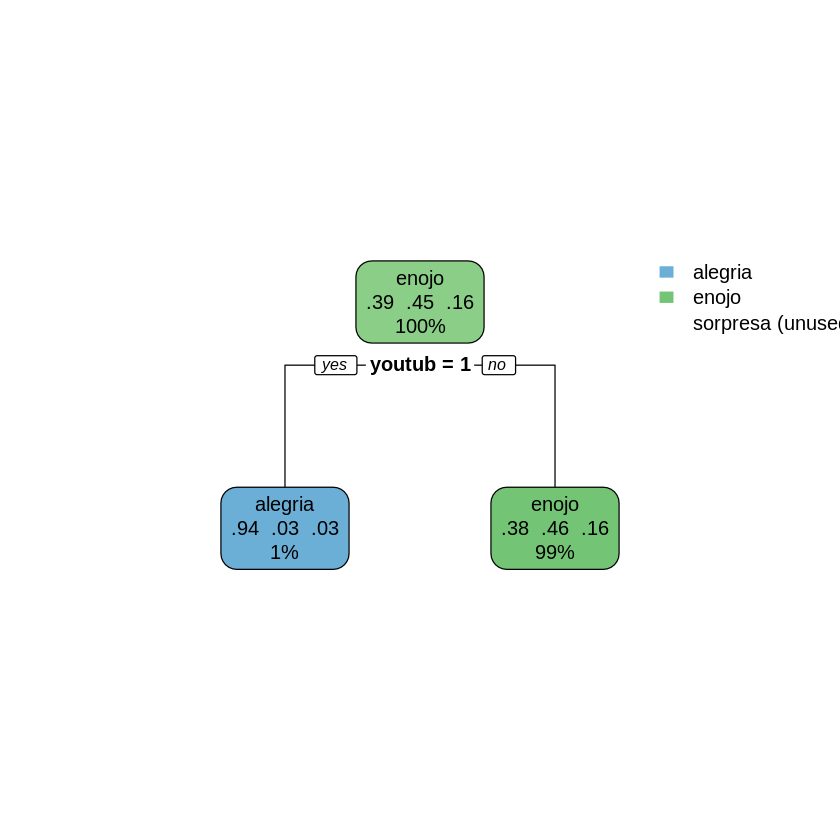

In [ ]:
#install.packages("rpart.plot")
cat("Árbol de decisiones con sparse 0,990\n")
rpart.plot::rpart.plot(DT_model_3)

Árbol de decisiones con sparse 0,995


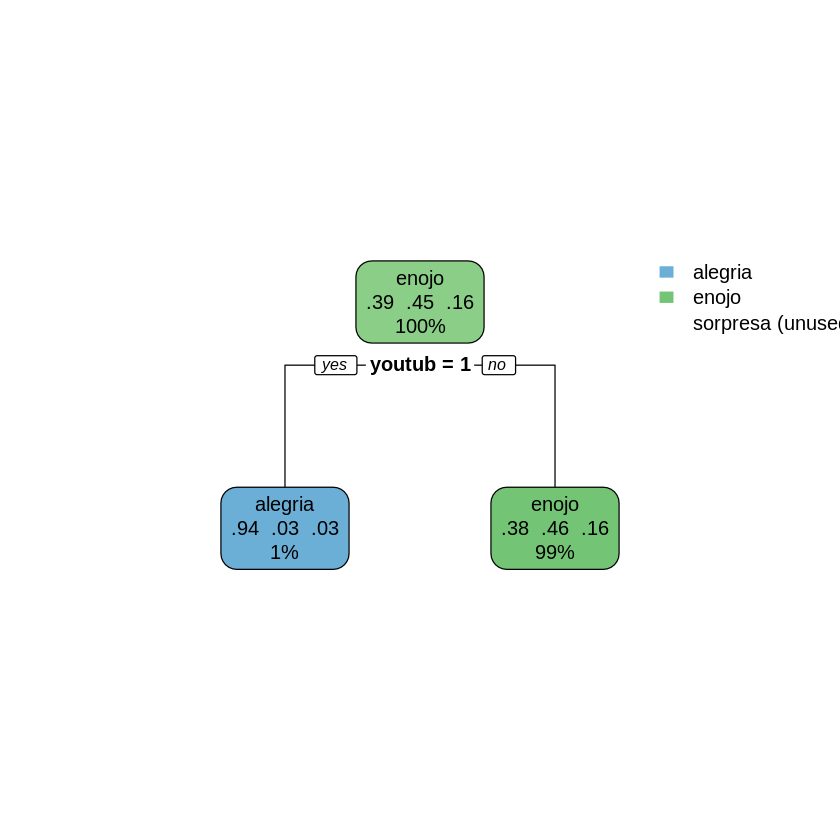

In [ ]:
cat("Árbol de decisiones con sparse 0,995\n")
rpart.plot::rpart.plot(DT_model_1)

Árbol de decisiones con sparse 0,998


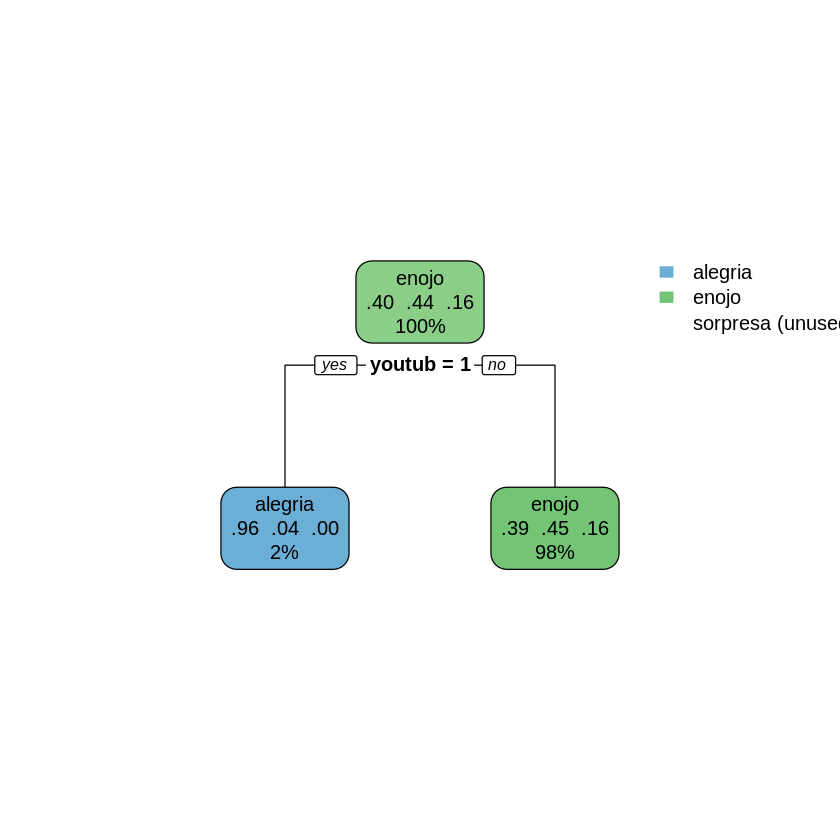

In [ ]:
cat("Árbol de decisiones con sparse 0,998\n")
rpart.plot::rpart.plot(DT_model_4)

In [ ]:
# Red Neuronal con sparce > 0,990
cat("Entrenando Red Neuronal 3\n")
set.seed(12345)
NN.model_3 <- nnet(
  formula = as.factor(emoción) ~ .,
  data = training.set_3,
  size = 20,
  maxit = 30,
  MaxNWts = 30000
)

Entrenando Red Neuronal 3
# weights:  1503
initial  value 5444.713630 
iter  10 value 4674.141237
iter  20 value 4572.355916
iter  30 value 4443.201823
final  value 4443.201823 
stopped after 30 iterations


In [ ]:
# Predicción de red neuronal con sparce > 0,990
NN.predict_3 <- predict(NN.model_3, testing.set_3, type = "class")

cat("********** Resultados Red Neuronal de 1 capa - Testing ***********\n")
cat("************** Corpus normalizado y Sparce > 0,990 ***************\n")
x3 <- testing.set_3[, 1:dim(corpus.procesado_3)[2] - 1]
y3 <- testing.set_3[, dim(corpus.procesado_3)[2]]
y.predicted_3 <- predict(NN.model_3, x3, type = 'class')
confusionMatrix(as.factor(y.predicted_3), y3)

********** Resultados Red Neuronal de 1 capa - Testing ***********
************** Corpus normalizado y Sparce > 0,990 ***************


Confusion Matrix and Statistics

          Reference
Prediction alegria enojo sorpresa
  alegria      283   197       73
  enojo        549   642      231
  sorpresa      33    38       25

Overall Statistics
                                          
               Accuracy : 0.4587          
                 95% CI : (0.4371, 0.4805)
    No Information Rate : 0.4235          
    P-Value [Acc > NIR] : 0.0006525       
                                          
                  Kappa : 0.0831          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       

Statistics by Class:

                     Class: alegria Class: enojo Class: sorpresa
Sensitivity                  0.3272       0.7320         0.07599
Specificity                  0.7761       0.3467         0.95924
Pos Pred Value               0.5118       0.4515         0.26042
Neg Pred Value               0.6166       0.6379         0.84608
Prevalence                   0.4177       0.4235        

In [ ]:

# Red Neuronal con sparce > 0,998
cat("Entrenando Red Neuronal 4\n")
set.seed(12345)
NN.model_4 <- nnet(
  formula = as.factor(emoción) ~ .,
  data = training.set_4,
  size = 20,
  maxit = 30,
  MaxNWts = 30000
)

Entrenando Red Neuronal 4
# weights:  12583
initial  value 9731.259108 
iter  10 value 4747.736979
iter  20 value 4140.905054
iter  30 value 3494.506441
final  value 3494.506441 
stopped after 30 iterations


In [ ]:
# Predicción de red neuronal con sparce > 0,998
NN.predict_4 <- predict(NN.model_4, testing.set_4, type = "class")

cat("********** Resultados Red Neuronal de 1 capa - Testing ***********\n")
cat("************** Corpus normalizado y Sparce > 0,998 ***************\n")
x4 <- testing.set_4[, 1:dim(corpus.procesado_4)[2] - 1]
y4 <- testing.set_4[, dim(corpus.procesado_4)[2]]
y.predicted_4 <- predict(NN.model_4, x4, type = 'class')
confusionMatrix(as.factor(y.predicted_4), y4)

********** Resultados Red Neuronal de 1 capa - Testing ***********
************** Corpus normalizado y Sparce > 0,998 ***************


Confusion Matrix and Statistics

          Reference
Prediction alegria enojo sorpresa
  alegria      411   376       97
  enojo        346   451      144
  sorpresa      72    93       81

Overall Statistics
                                          
               Accuracy : 0.4553          
                 95% CI : (0.4337, 0.4771)
    No Information Rate : 0.4442          
    P-Value [Acc > NIR] : 0.159856        
                                          
                  Kappa : 0.1054          
                                          
 Mcnemar's Test P-Value : 0.001178        

Statistics by Class:

                     Class: alegria Class: enojo Class: sorpresa
Sensitivity                  0.4958       0.4902         0.25155
Specificity                  0.6192       0.5743         0.90566
Pos Pred Value               0.4649       0.4793         0.32927
Neg Pred Value               0.6479       0.5850         0.86795
Prevalence                   0.4003       0.4442        

In [ ]:
# Generación del corpus no nomralizado y con eliminación de las palabras que
# tengan 0s en más del 99,8% de las filas (mensajes de Twitter).
corpus.procesado_5 <- DocumentTermMatrix(corpus.original) %>%
  removeSparseTerms(sparse = 0.998) %>%
  as.matrix() %>%
  as.data.frame() %>%
  mutate(emoción = as.factor(commentsdataset$emoción))
cat("\nCorpus no normalizado con eliminación del 99,8%")
dim(corpus.procesado_5)

ratio_5 <- sample(nrow(corpus.procesado_3), nrow(corpus.procesado_3) * 0.70)
training.set_5 = corpus.procesado_5[ratio_5, ]
testing.set_5 = corpus.procesado_5[-ratio_5, ]
cat(
  "\nDimensiones de datasets de entrenamiento/validación con sparse 0,990.\n",
  "Corpus sin normalizar.\n",
  sep = ""
)
dim(training.set_5)
dim(testing.set_5)


Corpus no normalizado con eliminación del 99,8%

[1] 6901  640


Dimensiones de datasets de entrenamiento/validación con sparse 0,990.
Corpus sin normalizar.


[1] 4830  640

[1] 2071  640

In [ ]:
# Red Neuronal con corpus sin normalizar y sparce > 0,998
cat("Entrenando Red Neuronal 5\n")
set.seed(12345)
NN.model_5 <- nnet(
  formula = as.factor(emoción) ~ .,
  data = training.set_5,
  size = 20,
  maxit = 30,
  MaxNWts = 30000
)

Entrenando Red Neuronal 5
# weights:  12863
initial  value 9567.874026 
iter  10 value 4675.098226
iter  20 value 4095.083767
iter  30 value 3538.202691
final  value 3538.202691 
stopped after 30 iterations


In [ ]:
# Predicción de red neuronal con corpus sin nromalizar y sparce > 0,998
NN.predict_5 <- predict(NN.model_5, testing.set_5, type = "class")

cat("********** Resultados Red Neuronal de 1 capa - Testing ***********\n")
cat("************* Corpus no normalizado y Sparce > 0,998 *************\n")
x5 <- testing.set_5[, 1:dim(corpus.procesado_5)[2] - 1]
y5 <- testing.set_5[, dim(corpus.procesado_5)[2]]
y.predicted_5 <- predict(NN.model_5, x5, type = 'class')
confusionMatrix(as.factor(y.predicted_5), y5)

********** Resultados Red Neuronal de 1 capa - Testing ***********
************* Corpus no normalizado y Sparce > 0,998 *************


Confusion Matrix and Statistics

          Reference
Prediction alegria enojo sorpresa
  alegria      404   377      122
  enojo        316   446      130
  sorpresa      87   120       69

Overall Statistics
                                          
               Accuracy : 0.4437          
                 95% CI : (0.4222, 0.4655)
    No Information Rate : 0.4553          
    P-Value [Acc > NIR] : 0.860189        
                                          
                  Kappa : 0.0931          
                                          
 Mcnemar's Test P-Value : 0.008762        

Statistics by Class:

                     Class: alegria Class: enojo Class: sorpresa
Sensitivity                  0.5006       0.4730         0.21495
Specificity                  0.6052       0.6046         0.88171
Pos Pred Value               0.4474       0.5000         0.25000
Neg Pred Value               0.6550       0.5785         0.85961
Prevalence                   0.3897       0.4553        

In [ ]:
#########################################################################
# Ajuste de parámetros de la red neuronal
#########################################################################
# Se trabajará con el corpus no normalizado y con un sparse de 0,995

# Original 100 nodos; sugeridos 20 nodos
nodos = seq(5, 50, 5)
# Original 50 iteraciones; sugeridas 30 iteraciones
iteraciones = seq(10, 100, 10)
# Ejecuta correctamente hasta 60 nodos y 100 iteraciones

# Tabla comparadora de modelos
comparador_nn <- tibble(
  Sentimiento = character(),
  Nodos = integer(),
  Iteraciones = integer(),
  Exactitud = numeric(),
  Sensibilidad = numeric(),
  Especificidad = numeric()
)

In [ ]:
for (nodo in nodos) {
  for (iteracion in iteraciones) {
    cat("\nEntrenando Red Neuronal:", nodo, "nodos,", iteracion, "iteraciones.")

    # Entrenamiento de la red neuronal auxiliar
    set.seed(12345)
    NN.model_aux <- nnet(
      formula = as.factor(emoción) ~ .,
      data = training.set_2,
      size = nodo,
      maxit = iteracion,
      MaxNWts = 30000
    )

    # Predicción de la red neuronal auxiliar
    y.predicted_aux <- predict(NN.model_aux, x2, type = 'class')
    matriz_auxiliar <- confusionMatrix(as.factor(y.predicted_aux), y2)

    for (numero in 1:3) {
      sentimiento <- case_when(
        numero == 1 ~ "Alegría",
        numero == 2 ~ "Enojo",
        numero == 3 ~ "Sorpresa"
      )
      comparador_nn <- bind_rows(
        comparador_nn,
        tibble(
          Sentimiento = sentimiento,
          Nodos = nodo,
          Iteraciones = iteracion,
          Exactitud = round(x = matriz_auxiliar$overall[1] * 100, digits = 2),
          Sensibilidad = round(
            x = matriz_auxiliar$byClass[numero, "Sensitivity"] * 100,
            digits = 2
          ),
          Especificidad = round(
            x = matriz_auxiliar$byClass[numero, "Specificity"] * 100,
            digits = 2
          )
        )
      )
    }
  }
}


Entrenando Red Neuronal: 5 nodos, 10 iteraciones.# weights:  1103
initial  value 5344.443929 
iter  10 value 4664.690759
final  value 4664.690759 
stopped after 10 iterations

Entrenando Red Neuronal: 5 nodos, 20 iteraciones.# weights:  1103
initial  value 5344.443929 
iter  10 value 4664.690759
iter  20 value 4436.242203
final  value 4436.242203 
stopped after 20 iterations

Entrenando Red Neuronal: 5 nodos, 30 iteraciones.# weights:  1103
initial  value 5344.443929 
iter  10 value 4664.690759
iter  20 value 4436.242203
iter  30 value 4224.672066
final  value 4224.672066 
stopped after 30 iterations

Entrenando Red Neuronal: 5 nodos, 40 iteraciones.# weights:  1103
initial  value 5344.443929 
iter  10 value 4664.690759
iter  20 value 4436.242203
iter  30 value 4224.672066
iter  40 value 3964.970460
final  value 3964.970460 
stopped after 40 iterations

Entrenando Red Neuronal: 5 nodos, 50 iteraciones.# weights:  1103
initial  value 5344.443929 
iter  10 value 4664.690759
iter  20 val

In [ ]:
# Problemas con 65 nodos y 10, 20 y 30 iteraciones; 75 nodos y 10 iteraciones.
comparador_nn

Sentimiento,Nodos,Iteraciones,Exactitud,Sensibilidad,Especificidad
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Alegría,5,10,47.46,57.80,56.47
Enojo,5,10,47.46,54.39,53.85
Sorpresa,5,10,47.46,1.82,99.31
Alegría,5,20,47.61,44.86,68.99
Enojo,5,20,47.61,62.94,47.74
Sorpresa,5,20,47.61,13.98,95.01
Alegría,5,30,45.34,55.03,57.46
Enojo,5,30,45.34,47.78,59.55
Sorpresa,5,30,45.34,13.37,92.19


In [ ]:
dataset_final <- comparador_nn %>%
  mutate(Diferencia_SE = abs(Sensibilidad - Especificidad))

In [ ]:
install.packages("writexl")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(writexl)

In [ ]:
write_xlsx(
  x = dataset_final,
  path = "sample_data/Comparador_NN.xlsx",
  col_names = TRUE
)